In [1]:
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,10)
warnings.filterwarnings("ignore")
sns.set()
os.chdir(r"C:\Users\Gilseung\Desktop\Jupyter\GILLAB\QUANT_DATA\201609~202108")

In [2]:
total_df = pd.DataFrame()
stock_file_name_list = os.listdir("투자지표") # 투자지표 폴더에 있는 모든 파일이 종목명으로 되어 있음

In [3]:
# 숫자에 콤마가 껴있어서 문자로 인식되는 경우를 처리하는 함수
def clean_str_num(value):
    if type(value) == str:
        return float(value.replace(',', ''))
    else:
        return value

In [4]:
for stock_file_name in stock_file_name_list:
    # 데이터 불러오기
    index_df = pd.read_csv("투자지표/{}".format(stock_file_name), encoding = "cp949") # 투자 지표 데이터
    index_df = index_df.iloc[1:] # 2021년 2분기 삭제

    for col in index_df.columns[:-1]:
        index_df[col] = index_df[col].apply(clean_str_num)

    index_df['실적발표날_날짜'] = [20210517, # 2021년 1분기
                                   20210330, 20201116, 20200914, 20200515, # 2020년 4분기, 3분기, 2분기, 1분기
                                   20200330, 20191114, 20190916, 20190515, # 2019년 4분기, 3분기, 2분기, 1분기
                                   20190401, 20181114]

    if stock_file_name in os.listdir("주가/KOSPI"):
        price_df = pd.read_csv("주가/KOSPI/{}".format(stock_file_name), encoding = "cp949") # 주가 데이터
    elif stock_file_name in os.listdir("주가/KOSDAQ"):
        price_df = pd.read_csv("주가/KOSDAQ/{}".format(stock_file_name), encoding = "cp949")
    
    df = pd.merge(price_df, index_df, left_on = "날짜", right_on = "실적발표날_날짜")
    
    # 현재 투자 지표를 보고 투자했을 때의 기대 이익 (손실)
    profit_ratio = (df['종가'].values[:-1] - df['종가'].values[1:]) / df['종가'].values[1:]
    profit_ratio = np.insert(profit_ratio, 0, np.nan)
    df['기대이익'] = profit_ratio
    
    total_df = pd.concat([total_df, df], axis = 0, ignore_index = True)

## 상관관계분석

In [5]:
X_cols = ['주당순이익(EPS,연결지배)', '주당순이익(EPS,개별)', 'PER (배)', '주당순자산(지분법)', 'PBR (배)', 'ROE (%)', '순이익률 (%)', '영업이익률 (%)']
total_df = total_df[X_cols + ["기대이익", "분기"]]

In [7]:
# 상관관계 분석: 대부분 유효하지 않음 -- 일단 선형 관계는 거의 없다고 봐도 무방
for col in X_cols:
    temp = total_df[[col, "기대이익"]].dropna() # x와 y 모두 결측이 아닌 경우만 걸러냄
    print(col, stats.pearsonr(temp[col], temp["기대이익"]))

주당순이익(EPS,연결지배) (-0.023501606654575888, 0.001223664655328655)
주당순이익(EPS,개별) (-0.014045705526774751, 0.05535752082755992)
PER (배) (-0.006042270957307113, 0.5031681746739781)
주당순자산(지분법) (-0.020031467617297544, 0.005163925456499579)
PBR (배) (-0.021778164916176724, 0.0024323358178777055)
ROE (%) (-0.002817288448270107, 0.7003011880693883)
순이익률 (%) (0.002017989958182369, 0.7880964027595667)
영업이익률 (%) (-0.0020154938519046676, 0.7918309408834031)


주당순이익(EPS,연결지배)


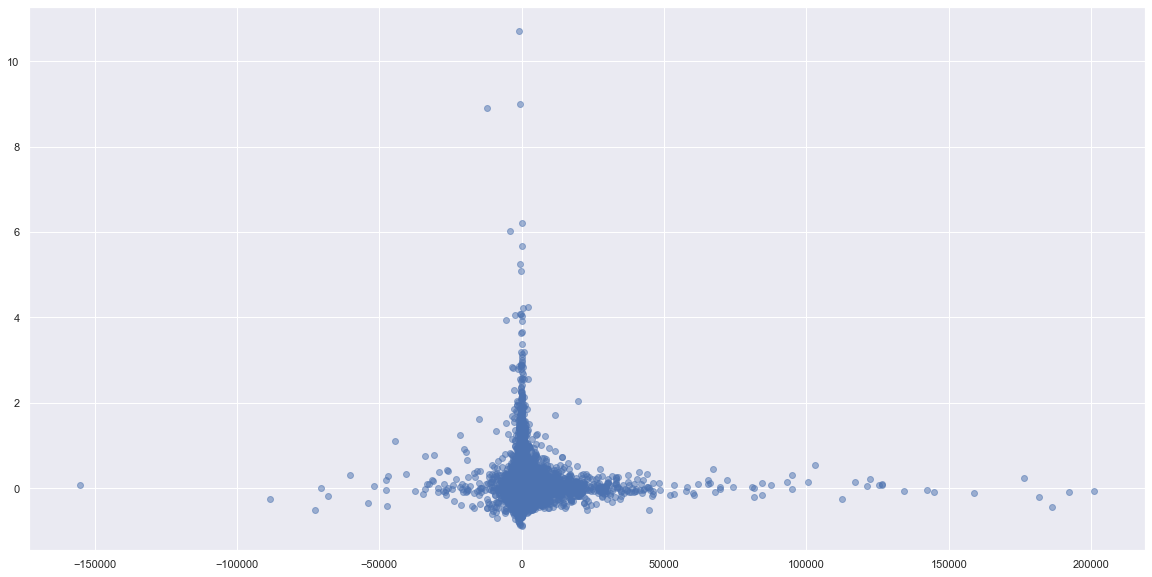

주당순이익(EPS,개별)


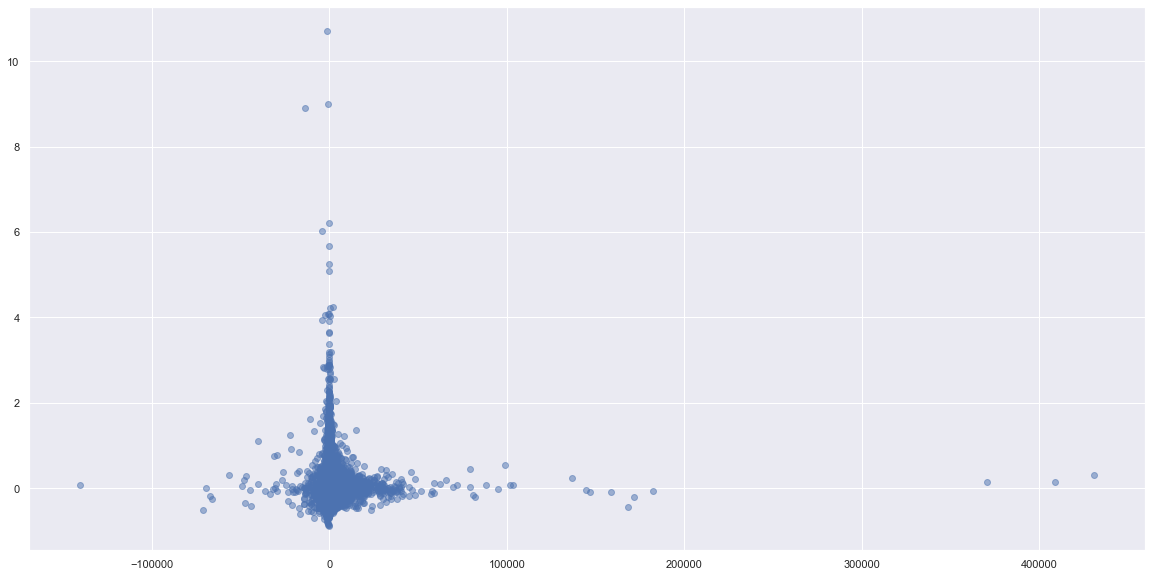

PER (배)


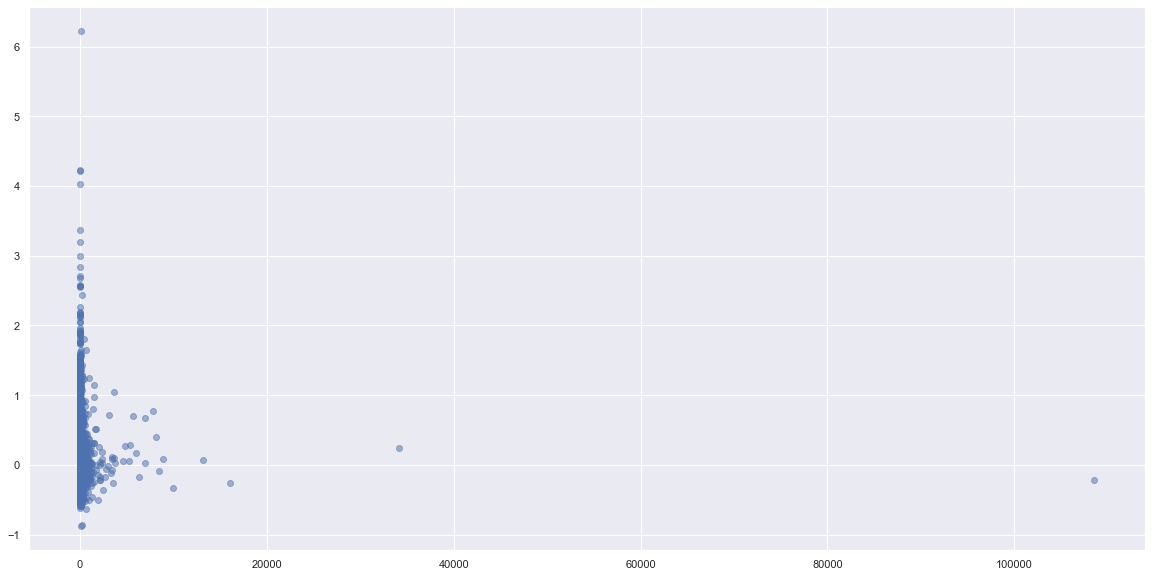

주당순자산(지분법)


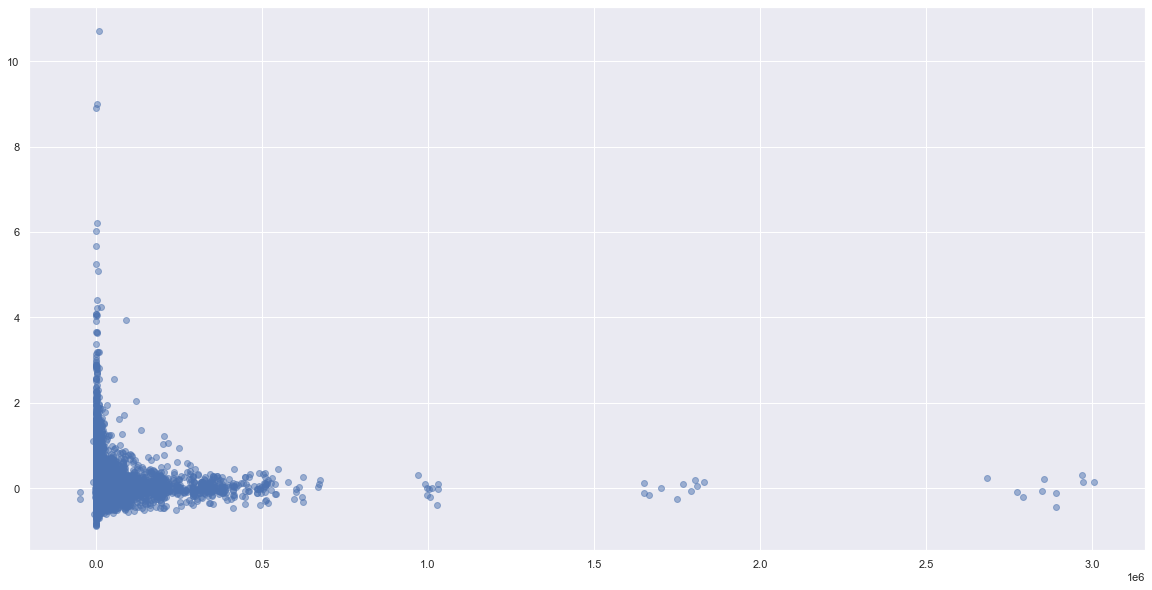

PBR (배)


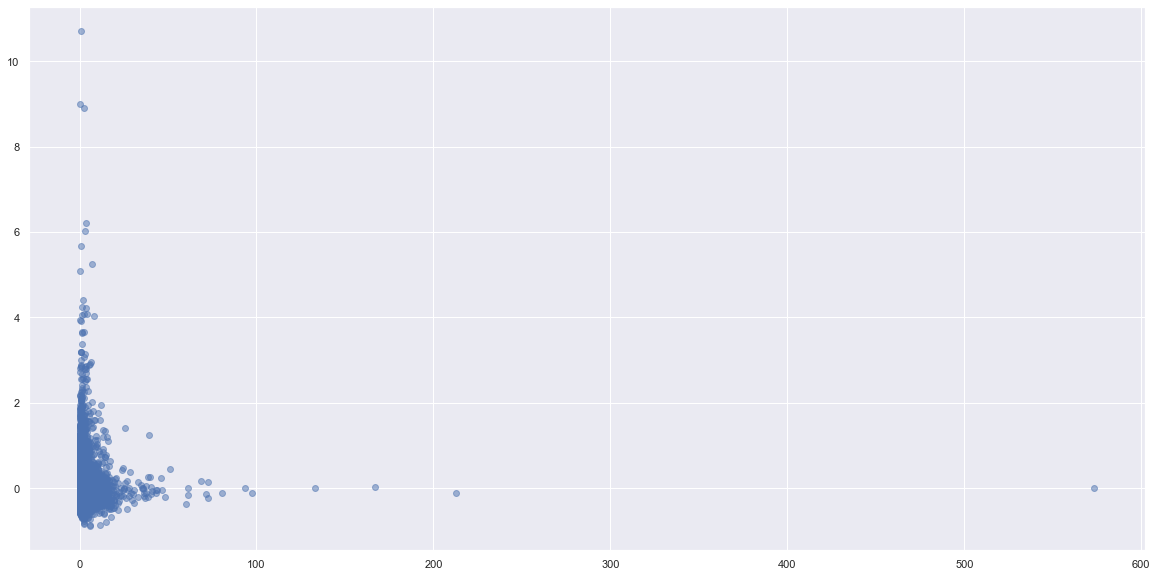

ROE (%)


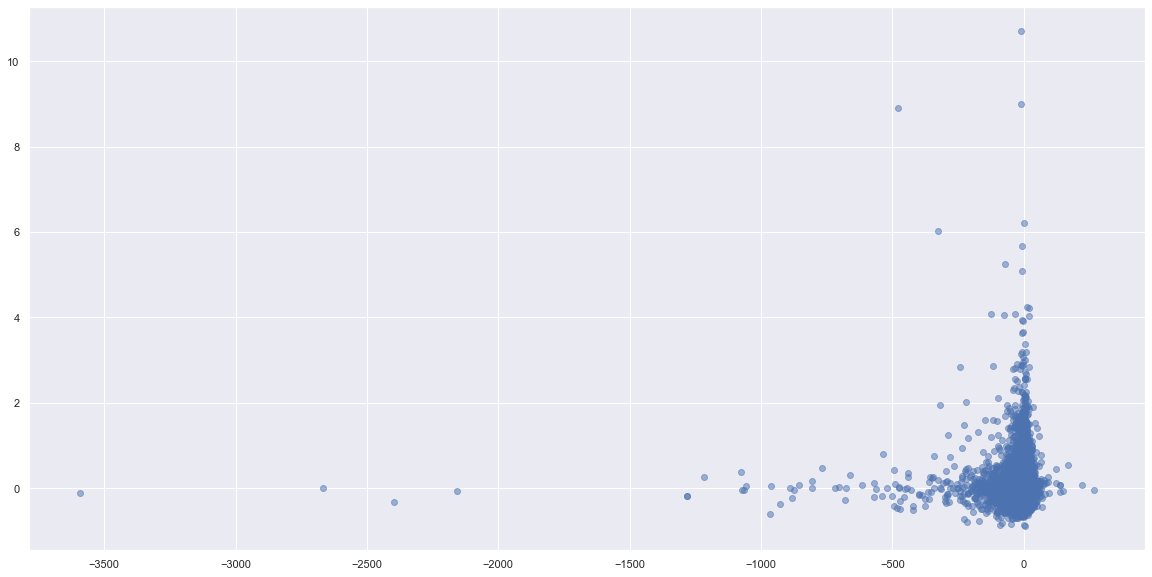

순이익률 (%)


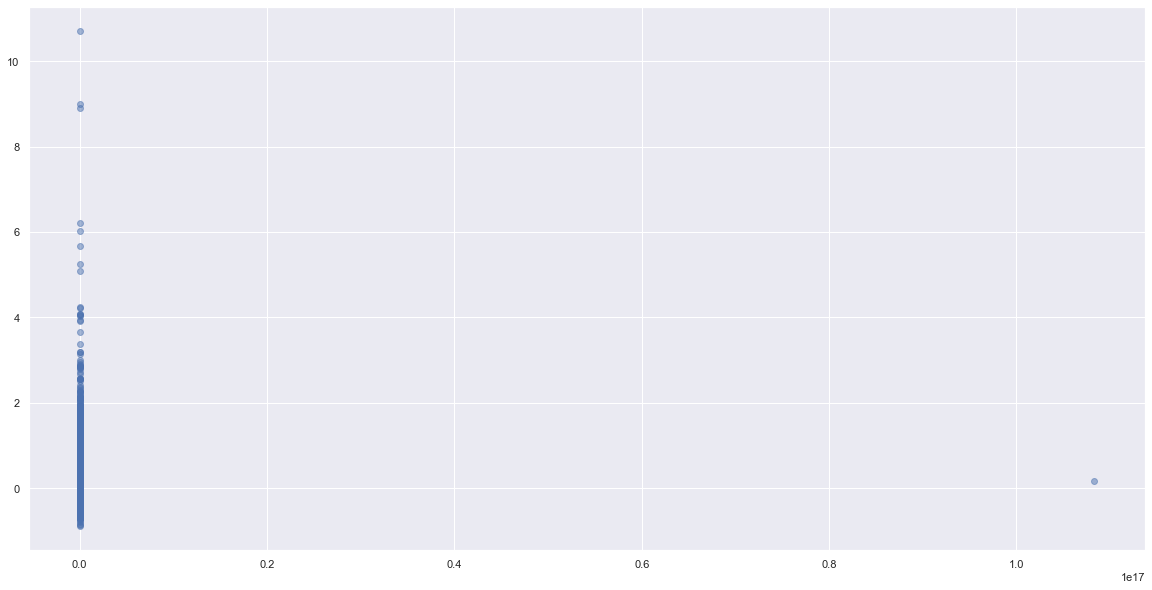

영업이익률 (%)


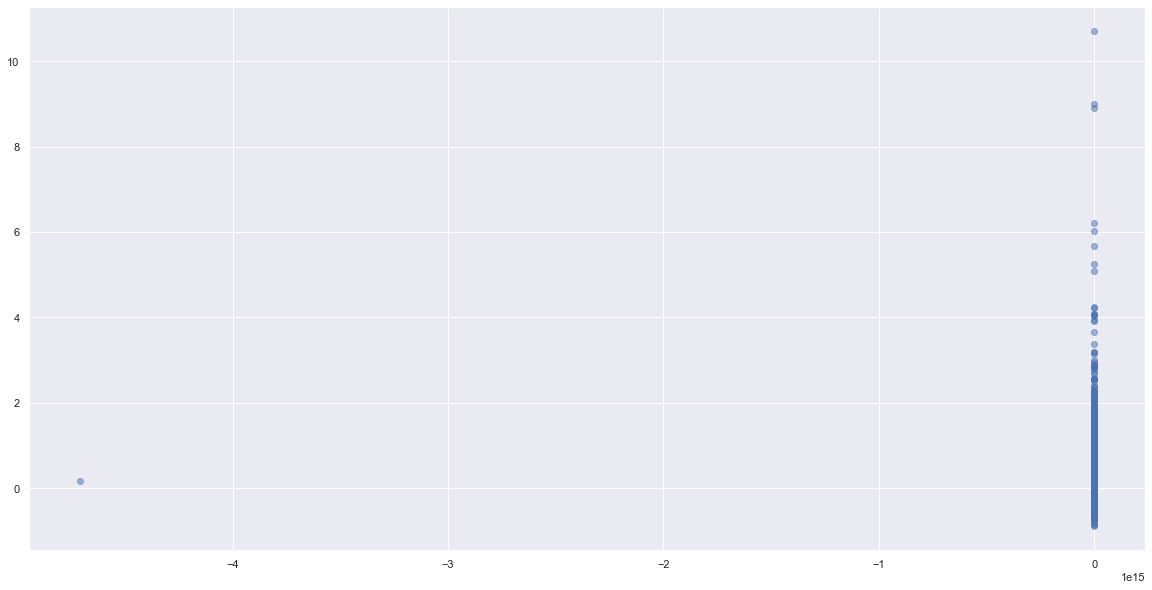

In [8]:
# 이상치가 일단 너무 많음 -- 이상치는 지우고 생각하자
for col in X_cols:
    print(col)
    temp = total_df[[col, "기대이익"]].dropna() # x와 y 모두 결측이 아닌 경우만 걸러냄
    plt.scatter(temp[col], temp['기대이익'], alpha = 0.5)
    plt.show()

In [9]:
def find_inlier(df, col):
    Q1 = np.quantile(df[col], 0.25)
    Q3 = np.quantile(df[col], 0.75)
    IQR = Q3 - Q1
    
    # outlier면 False, inlier면 True
    return (df[col] < Q3 + 1.5 * IQR) & (df[col] > Q1 - 1.5 * IQR)

주당순이익(EPS,연결지배)


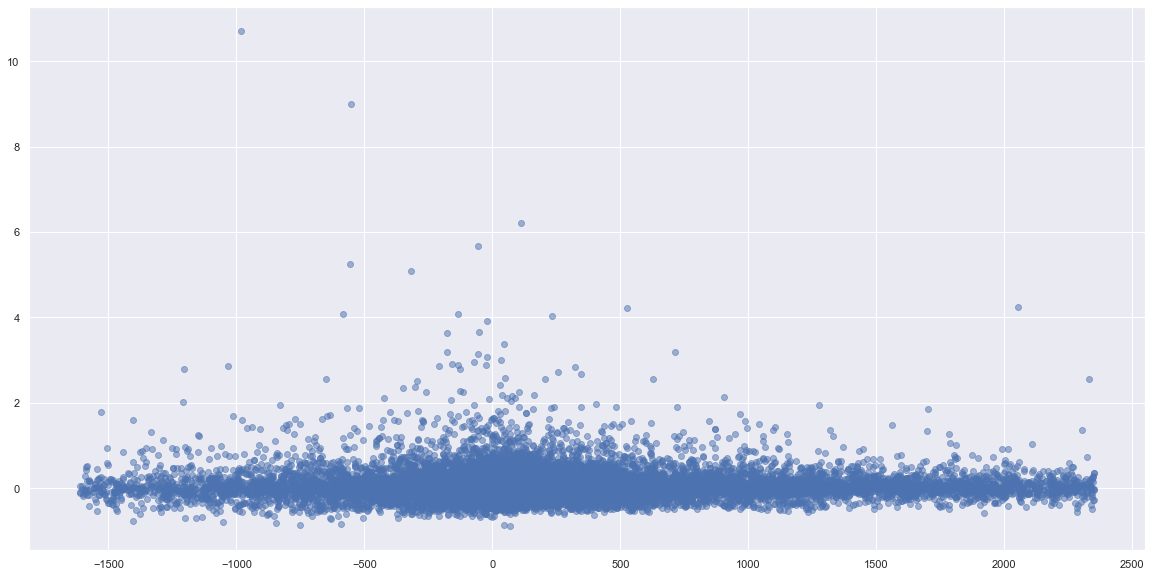

주당순이익(EPS,개별)


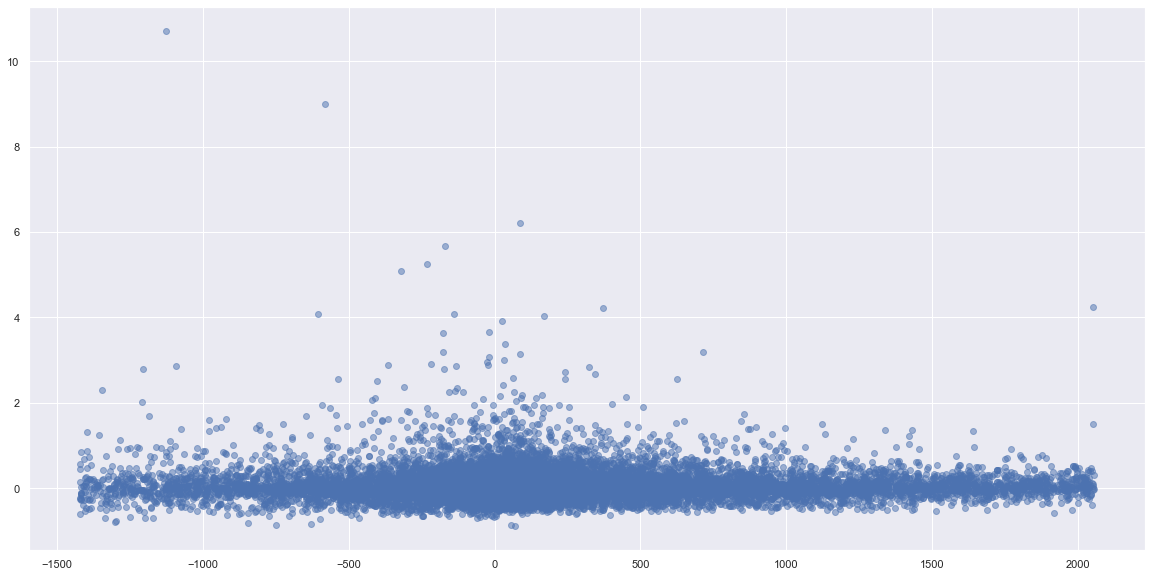

PER (배)


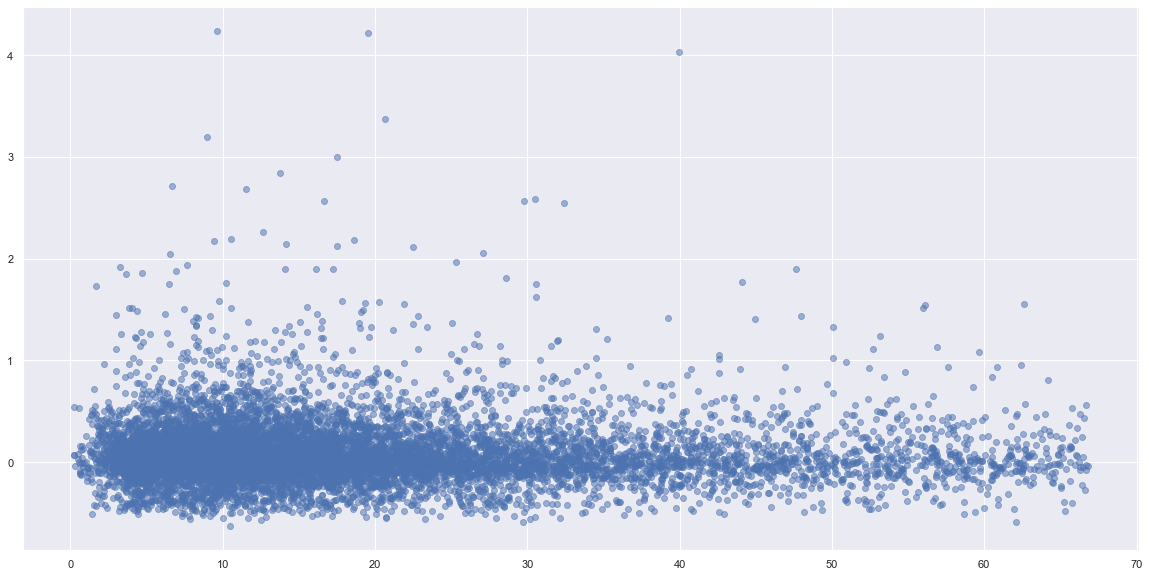

주당순자산(지분법)


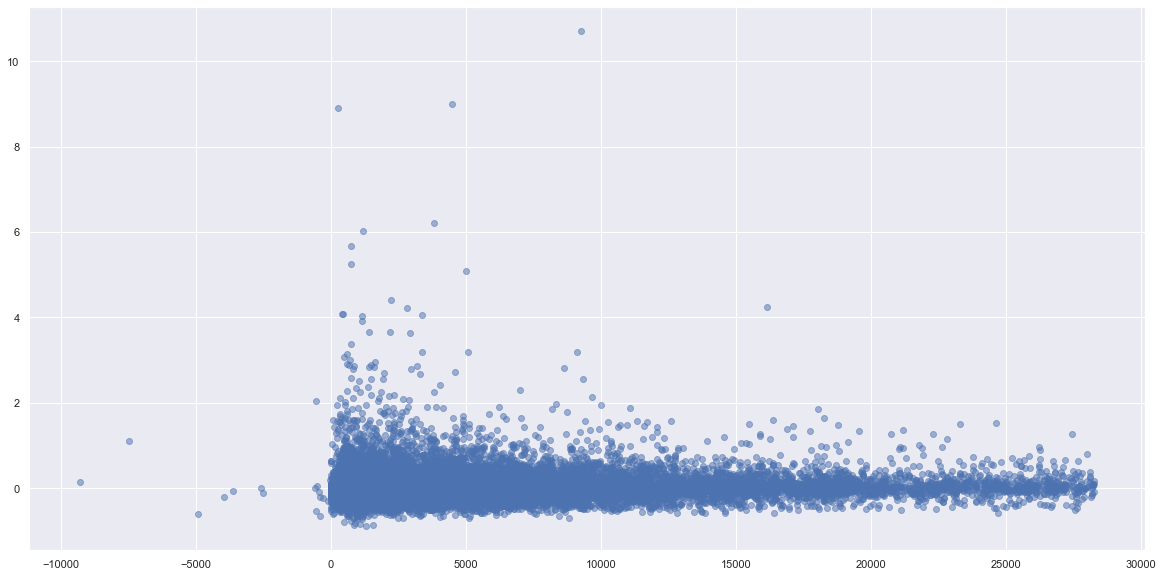

PBR (배)


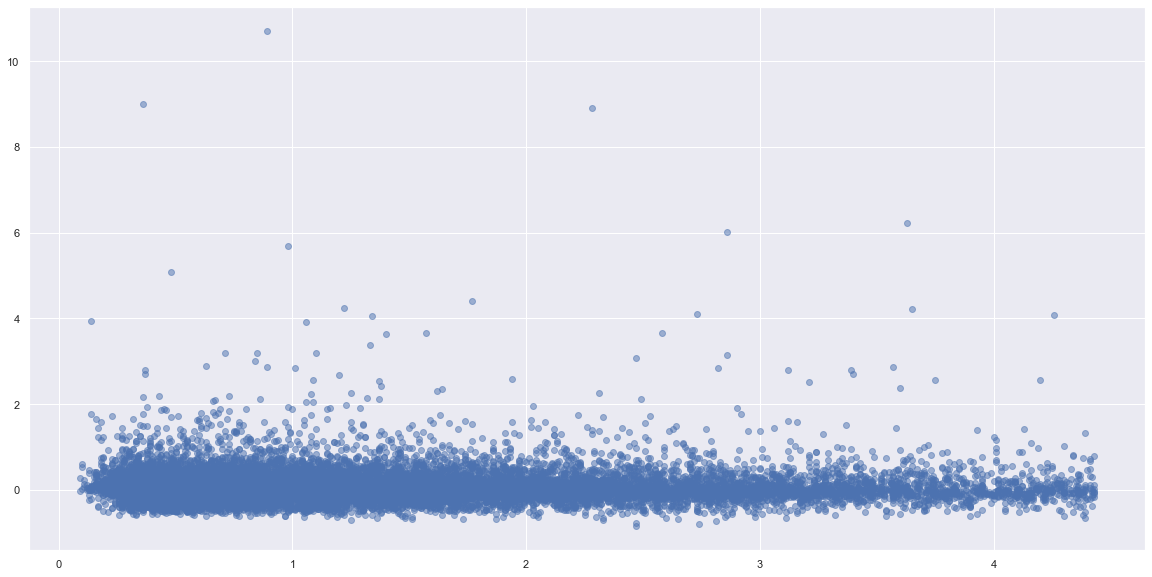

ROE (%)


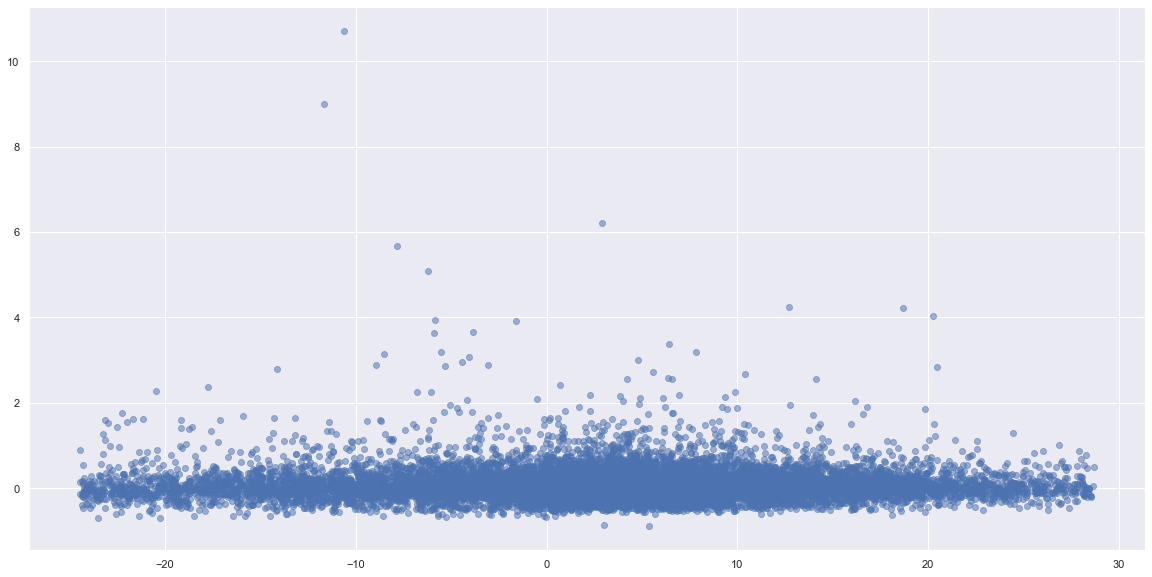

순이익률 (%)


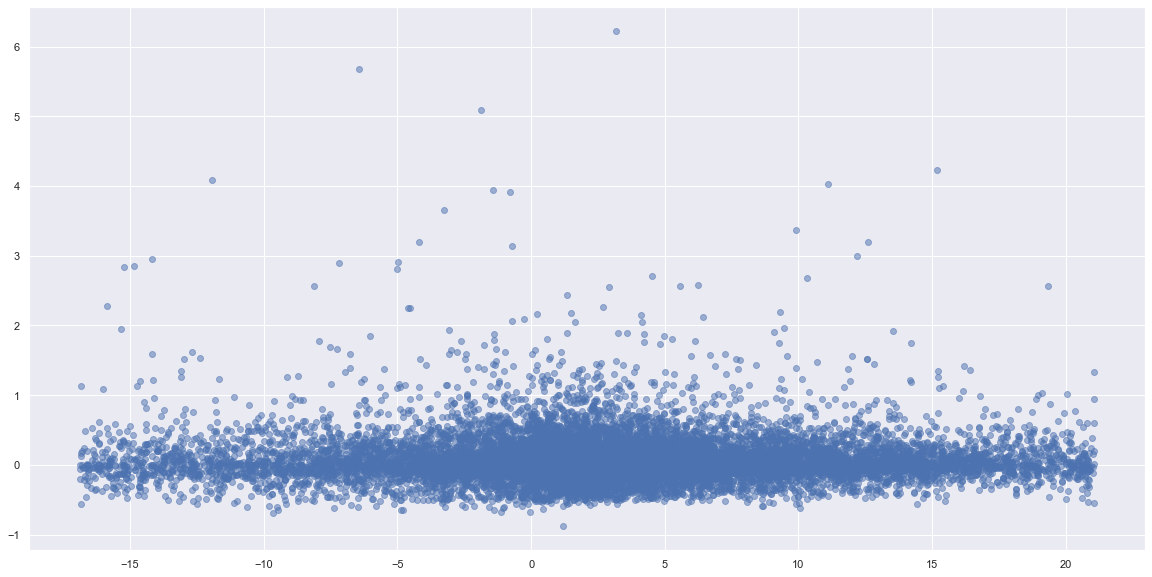

영업이익률 (%)


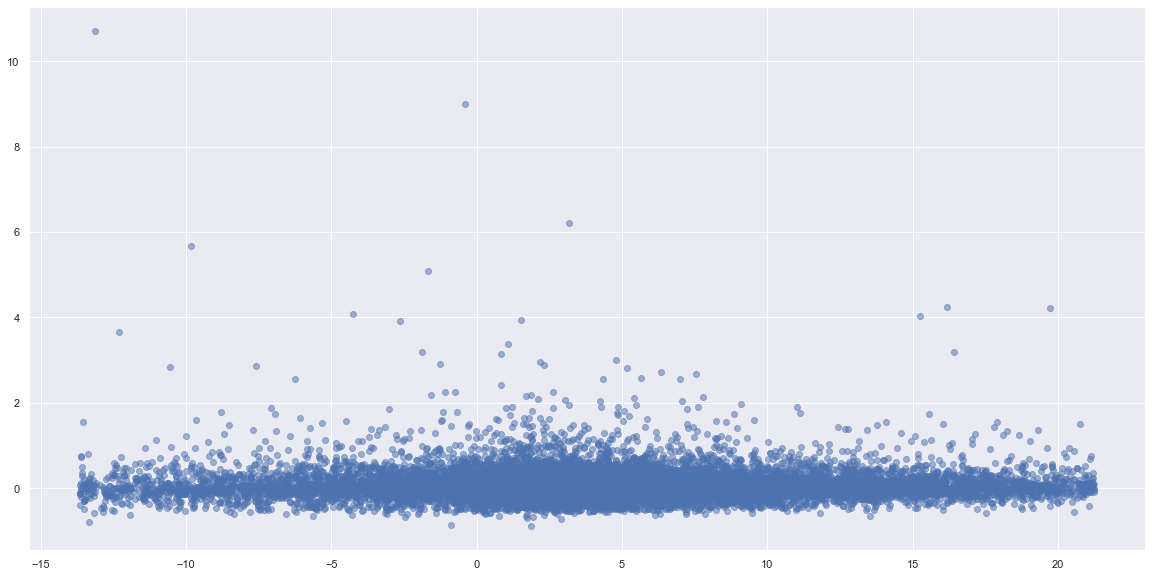

In [10]:
for col in X_cols:
    print(col)
    temp = total_df[[col, "기대이익"]].dropna()
    temp = temp.loc[find_inlier(temp, col)]
    plt.scatter(temp[col], temp['기대이익'], alpha = 0.5)
    plt.show()

## t-test

주당순이익(EPS,연결지배)
수익 그룹 평균:247.2405807120636, 손실 그룹 평균: 207.50150753768844, t-test 결과 (p-value): 0.00033720065231984827


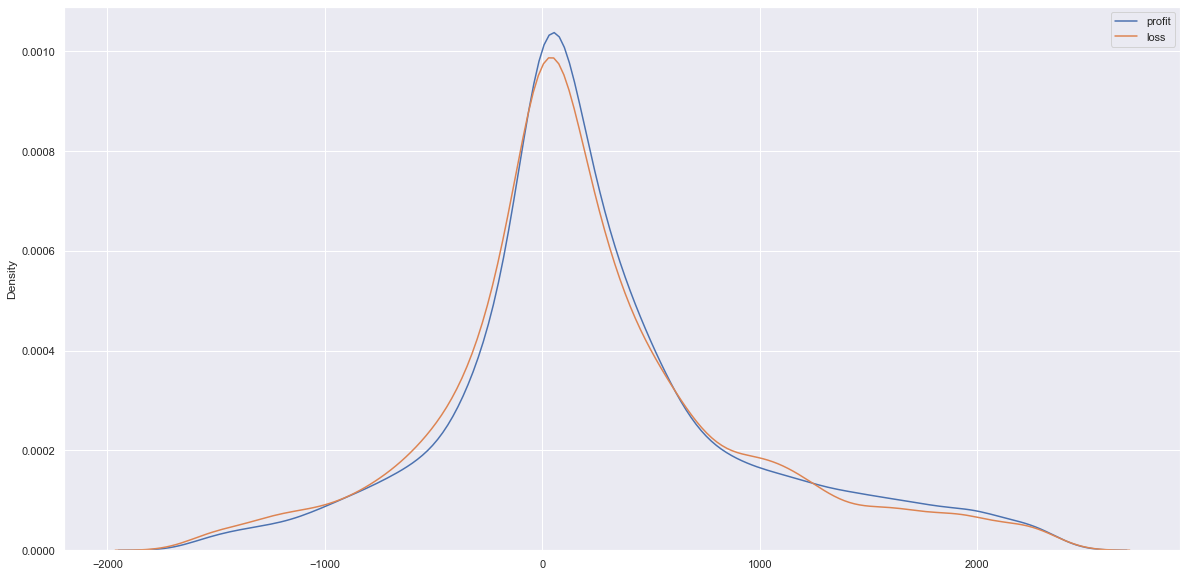

주당순이익(EPS,개별)
수익 그룹 평균:215.88193956430078, 손실 그룹 평균: 189.2781855549031, t-test 결과 (p-value): 0.007547795827527739


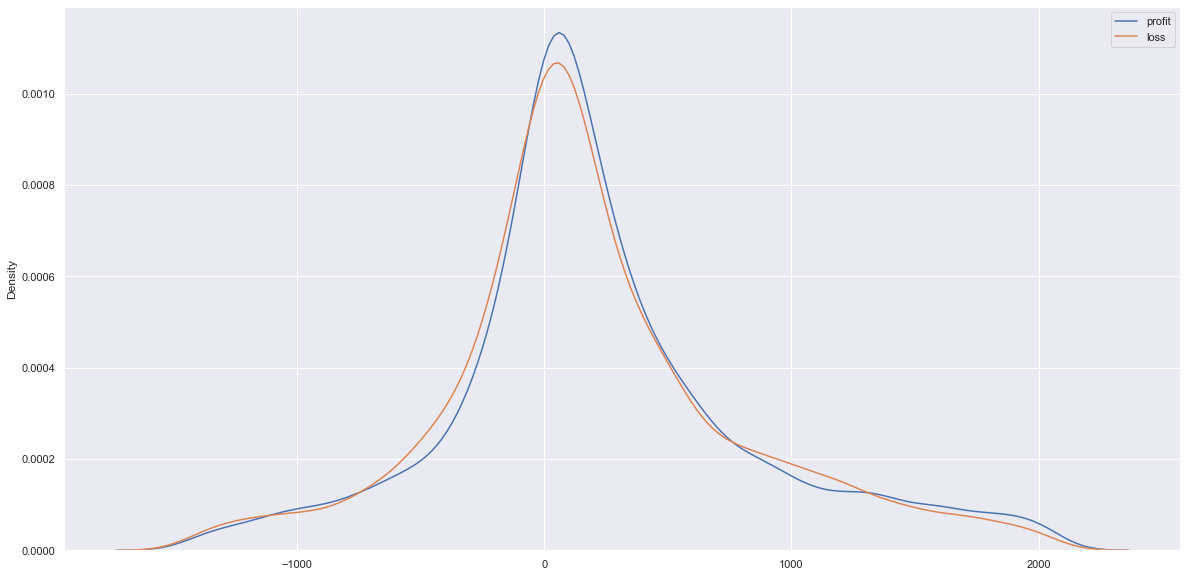

PER (배)
수익 그룹 평균:17.727183327906218, 손실 그룹 평균: 19.02762184508268, t-test 결과 (p-value): 1.2662250659079291e-06


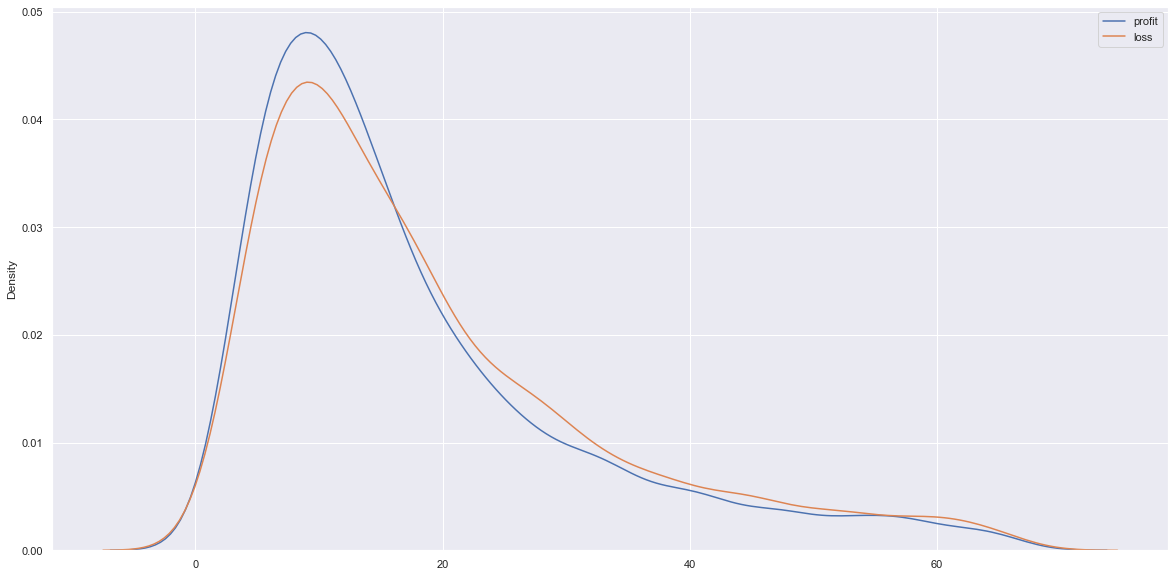

주당순자산(지분법)
수익 그룹 평균:6504.083224543081, 손실 그룹 평균: 6201.527217206585, t-test 결과 (p-value): 0.001087489351046833


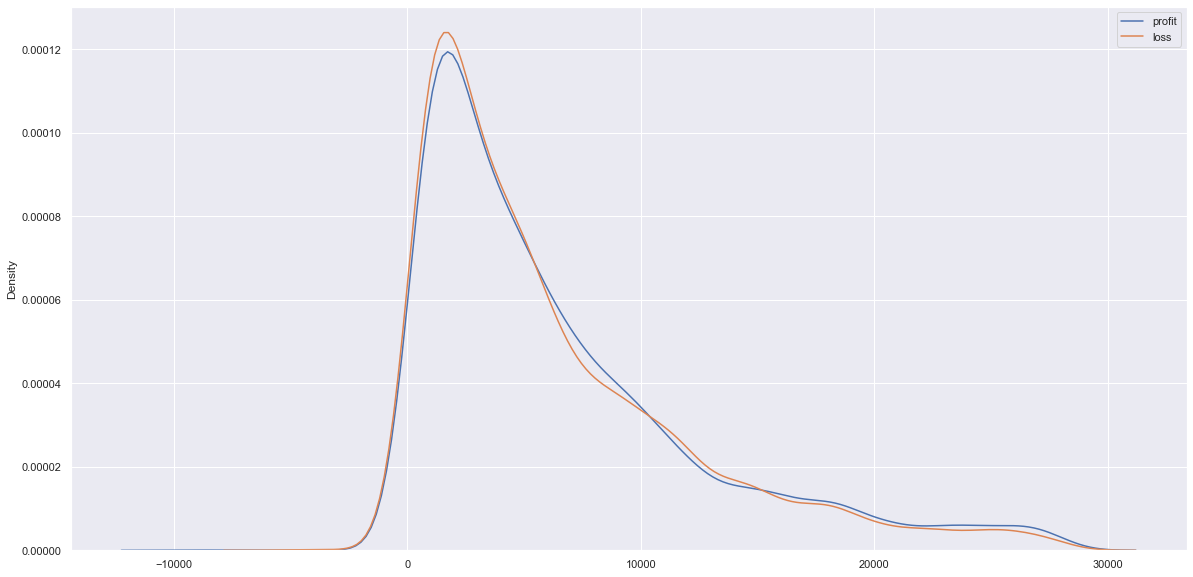

PBR (배)
수익 그룹 평균:1.2846524550414224, 손실 그룹 평균: 1.4345503805960522, t-test 결과 (p-value): 1.522704457412984e-25


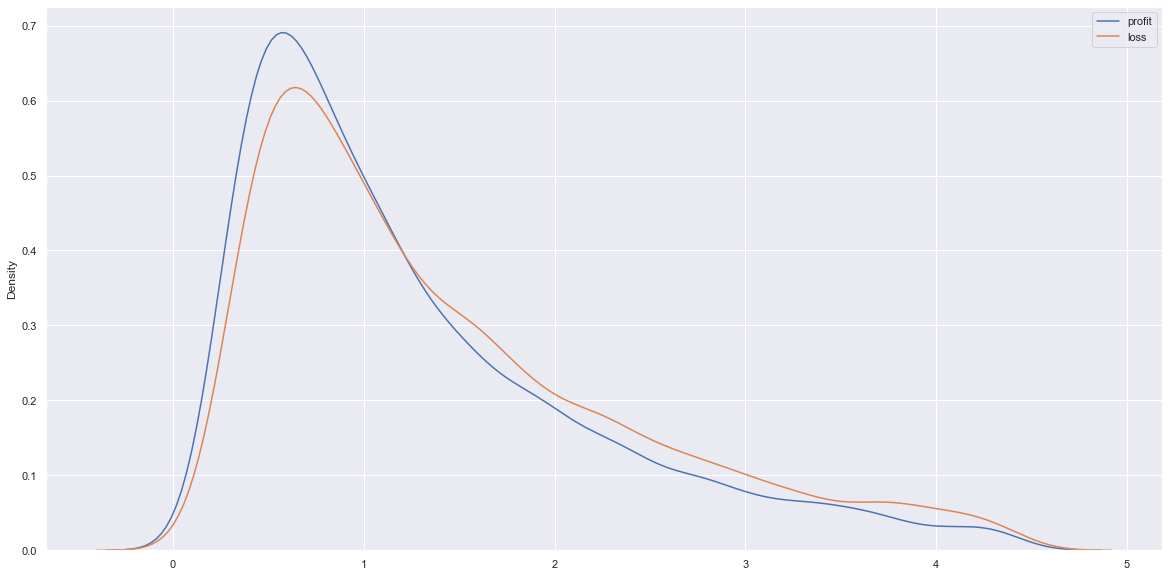

ROE (%)
수익 그룹 평균:3.8716748822433997, 손실 그룹 평균: 3.410625347415231, t-test 결과 (p-value): 0.0019309731746970135


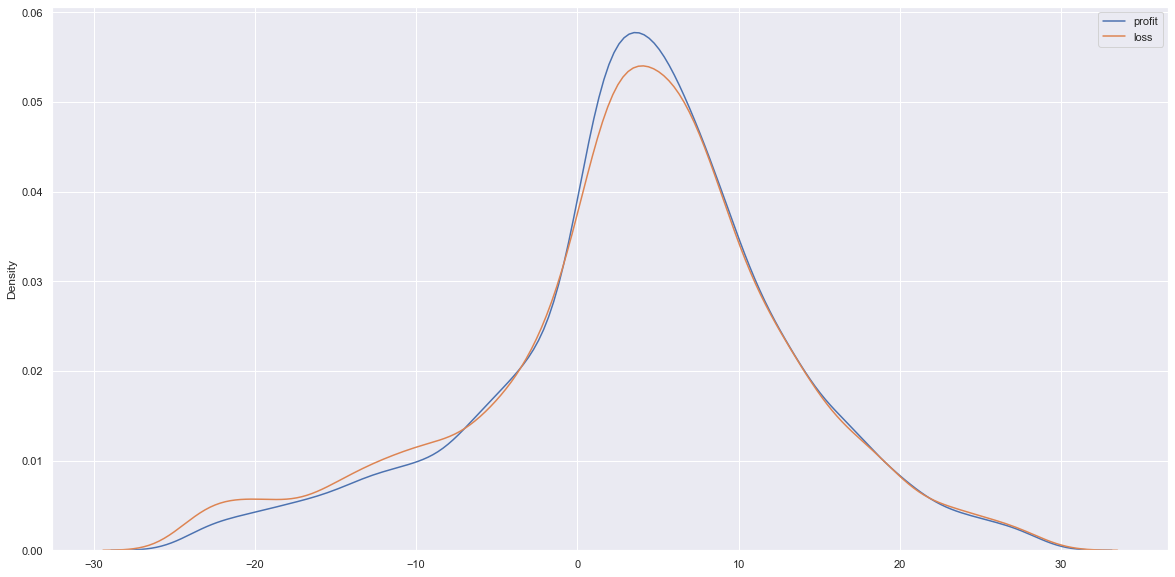

순이익률 (%)
수익 그룹 평균:3.0418068799034397, 손실 그룹 평균: 2.8893456924754632, t-test 결과 (p-value): 0.18098882784109524


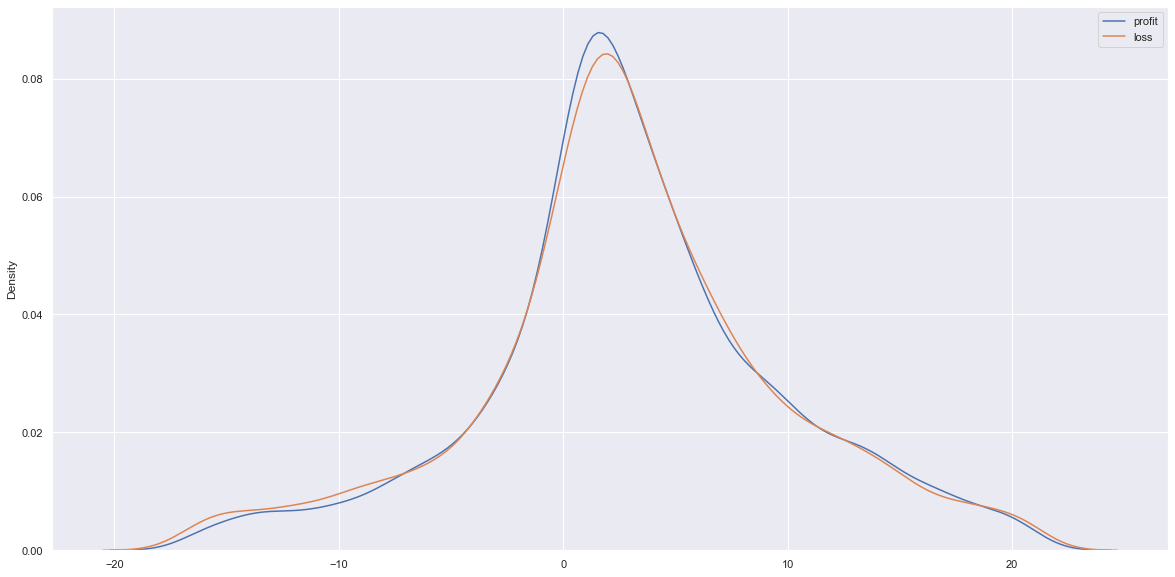

영업이익률 (%)
수익 그룹 평균:4.284849221789883, 손실 그룹 평균: 4.116784932791497, t-test 결과 (p-value): 0.11824518977168452


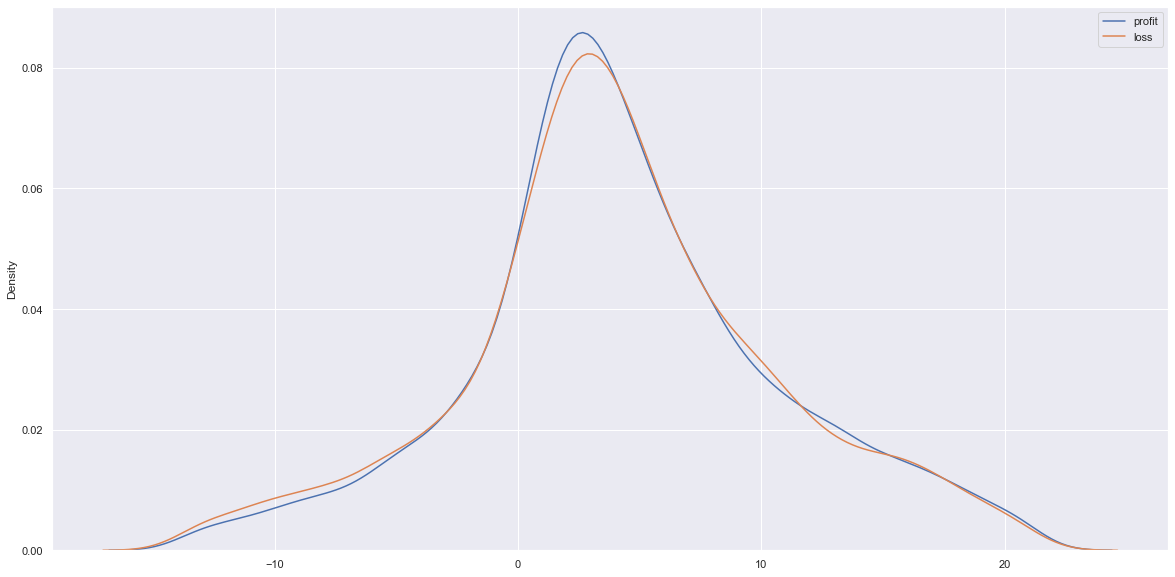

In [11]:
for col in X_cols:
    # 이상치 제거
    temp = total_df[[col, "기대이익"]].dropna()
    temp = temp.loc[find_inlier(temp, col)]
    
    good = temp.loc[total_df['기대이익'] > 0, col].values
    bad = temp.loc[total_df['기대이익'] < 0, col].values
    
    print(col)
    print("수익 그룹 평균:{}, 손실 그룹 평균: {}, t-test 결과 (p-value): {}".format(good.mean(), bad.mean(), stats.ttest_ind(good, bad)[1]))

    sns.distplot(good, label = "profit", hist = False)
    sns.distplot(bad, label = "loss", hist = False)
    
    plt.legend()
    plt.show()

## p-value가 0.05 미만인 항목에서 중심을 기준으로 백테스트

In [12]:
def backtest(seedmoney, A, B):
    # 동일한 금액으로 각 종목에 투자
    A_money = np.array([seedmoney / len(A)] * len(A))
    B_money = np.array([seedmoney / len(B)] * len(B))
    
    A_money = A_money * (A + 1)
    B_money = B_money * (B + 1)
    
    return int(A_money.sum() - B_money.sum()) # A에 투자했을 때 이익 - B에 투자했을 때 이익

In [13]:
# PER과 PBR만 이익이 나는 것을 확인
for col in X_cols:
    # 이상치 제거
    temp = total_df[[col, "기대이익"]].dropna()
    temp = temp.loc[find_inlier(temp, col)]
    
    good = temp.loc[total_df['기대이익'] > 0, col].values.mean() # 수익이 나는 그룹의 평균
    bad = temp.loc[total_df['기대이익'] < 0, col].values.mean() # 손실이 나는 그룹의 평균
    
    threshold = (good + bad) / 2 # good과 bad의 중간으로 설정
    
    if good > bad: 
        good_group = temp.loc[total_df[col] > threshold, '기대이익'].values
        bad_group = temp.loc[total_df[col] < threshold, '기대이익'].values
    
    elif bad > good:
        good_group = temp.loc[total_df[col] < threshold, '기대이익'].values
        bad_group = temp.loc[total_df[col] > threshold, '기대이익'].values
    
    print(col, good, bad, backtest(10e8, good_group, bad_group))

주당순이익(EPS,연결지배) 247.2405807120636 207.50150753768844 -11328557
주당순이익(EPS,개별) 215.88193956430078 189.2781855549031 -18294122
PER (배) 17.727183327906218 19.02762184508268 11213870
주당순자산(지분법) 6504.083224543081 6201.527217206585 -19157626
PBR (배) 1.2846524550414224 1.4345503805960522 14063710
ROE (%) 3.8716748822433997 3.410625347415231 -7672936
순이익률 (%) 3.0418068799034397 2.8893456924754632 -9219937
영업이익률 (%) 4.284849221789883 4.116784932791497 -6776592


In [14]:
PER_threshold = (17.727183327906218 + 19.02762184508268) / 2
PBR_threshold = (1.2846524550414224 + 1.4345503805960522) / 2

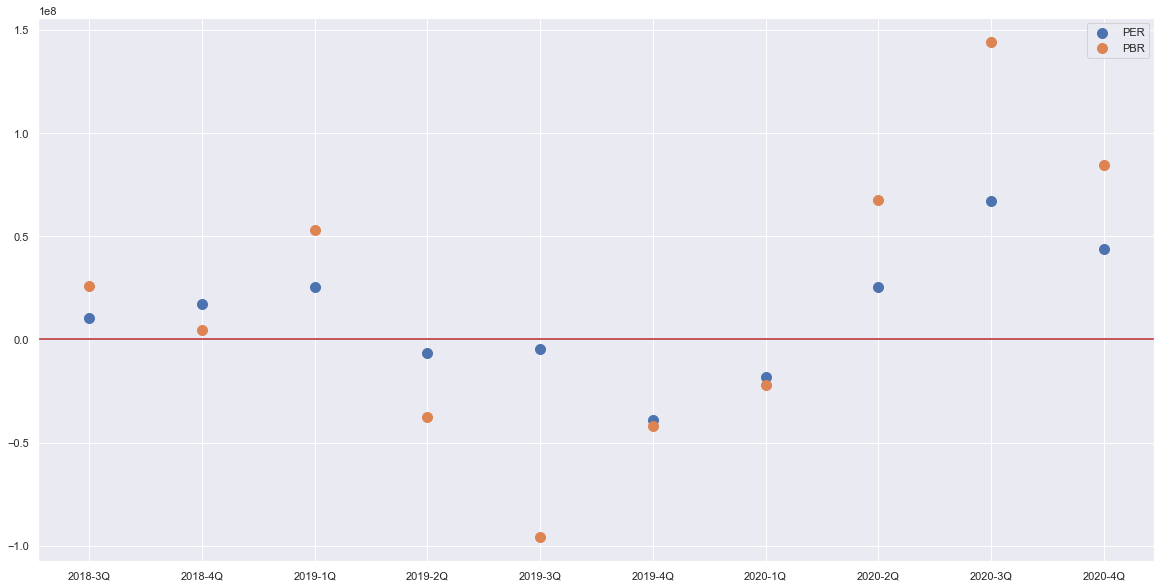

In [15]:
# PER과 PBR만 이익이 나는 것을 확인 
# 분기별로 확인
Q_list = ['2020-4Q', '2020-3Q', '2020-2Q', '2020-1Q', '2019-4Q', '2019-3Q',
          '2019-2Q', '2019-1Q', '2018-4Q', '2018-3Q']
Q_list = sorted(Q_list, reverse = False)

for col, threshold in zip(["PER (배)", "PBR (배)"], [PER_threshold, PBR_threshold]):
    backtest_result = []
    for Q in Q_list: 
        temp = total_df.loc[total_df["분기"] == Q, [col, "기대이익"]].dropna()
        good_group = temp.loc[temp[col] < threshold, '기대이익'].values
        bad_group = temp.loc[temp[col] >= threshold, '기대이익'].values
        backtest_result.append(backtest(10e8, good_group, bad_group))
    
    plt.scatter(range(len(backtest_result)), backtest_result, s = 100, label = col.split(' ')[0])
    plt.xticks(range(len(Q_list)), Q_list)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.legend()